In [298]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [534]:
# Numero de clientes

file = open("d_difficult.in.txt", "r")
clients = file.readline()
file.close()
clients = int(clients[:-1])
clients

9368

In [535]:
# Hay un max de 5 ingredientes
df = pd.read_csv("d_difficult.in.txt", sep = " ", skiprows = 1, names = ["count", "ing1",  "ing2", "ing3", "ing4", "ing5"])
df.fillna("sendpepes", inplace=True) # antes esto era necesario, se puede cambiar por fillna(0), pero me hace gracia y se queda
listIng = list(ingredients)
listIng
df = df.replace({'ingredient': '', 'sendpepes':0}, regex=True)
df = df.astype(int)

# Set con todos los ingredientes sin repetir
ingredients = set(df.ing1.unique())
ingredients = ingredients.union(set(df.ing2.unique()))
ingredients = ingredients.union(set(df.ing3.unique()))
ingredients = ingredients.union(set(df.ing4.unique()))
ingredients = ingredients.union(set(df.ing5.unique()))
ingredients.discard(0)

listIng = list(ingredients)
df

,count,ing1,ing2,ing3,ing4,ing5
0,3,319,79,123,0,0
1,0,0,0,0,0,0
2,1,550,0,0,0,0
3,2,34,478,0,0,0
4,1,552,0,0,0,0
...,...,...,...,...,...,...
18731,2,44,274,0,0,0
18732,1,426,0,0,0,0
18733,1,332,0,0,0,0
18734,2,352,429,0,0,0


In [536]:
##### NO USAR ESTO, VER SIGUIENTE BLOQUE #####

data = pd.DataFrame(columns=["likeCount"] + listIng, index=range(clients))
for i in listIng:
    aux = df.isin([i]).sum(axis=1)
    like = aux[::2].values
    dislike = aux[1::2].values
    data.loc[:,i] = like - dislike
    print(i)
data.likeCount = df.loc[::2, "count"].values


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114



KeyboardInterrupt



In [537]:
# Guardamos los gustos de cada cliente en una matriz, con nrows = clientes, ncols = num_ingredientes
# 1: gusta
# -1: no gusta

data = np.zeros([clients, len(listIng)+1], int)
for c in range(clients):
    for i in range(1,6):
        x = df.iloc[2*c,i]
        if x > 0:
            data[c, x] = 1
        x = df.iloc[2*c+1,i]
        if x > 0:
            data[c, x] = -1
            
# Vector con el numero de gustos de cada cliente
counts = np.array(df.loc[::2,"count"].values)

# Habia un ingrediente 0 que correspondia con NaN, quitamos la columna correspondiente
data = data[:, 1:]


# ALGORITMO GENETICO FTW

In [597]:
#### PARAMETROS

#Tamaño de poblacion
popSize = 1000

# Fraccion de indivs que sobreviven tal cual para la siguiente generacion
survivalRate = 0.05

# Fraccion de los genes que pasan a nuevos hijos
inheritRate = 0.5

# Crear poblacion inicial. Una poblacion sera una matriz popSize x numIng de 0 y 1,
# donde 1 representa que la pizza lleva el ing correspondiente

numIng = len(listIng)


def create_population(popSize=popSize, numIng = numIng):
    #matriz aleatoria con entradas en (0,1), redondeada
    popini = np.random.rand(numIng, popSize).round()
    return popini.astype(int)

def scoring(population, data, clients=clients, popSize=popSize):
    #Multiplica matriz de los gustos/disgustos por el vector que representa la pizza. Resulta en un vector de dim 1 x numero_clientes
    scoreMatrix = np.dot(data, population)
    
    # Para cada individuo de la poblacion
    for p in range(popSize):
        # Si la pizza tiene todos los ingred que le gustan al indiv, y ninguno que le gusta, cambia el valor a True; False en caso contrario
        scoreMatrix[:,p] = scoreMatrix[:,p] >= counts
    return scoreMatrix.sum(axis=0) # Devuelve suma de clientes que compran (suma los True)

def next_generation(population, popSize = popSize, survivalRate = survivalRate, scores=scores, inheritRate=inheritRate):
    # Indices de individuos que NO sobreviven
    cutoff = int(popSize * (1 - survivalRate)) #Num indivs nuevos a generar
    survivors = popSize - cutoff
    
    idx = np.argsort(scores) 
    survidx = idx[cutoff:] # indices de los que si sobreviven
    idx = idx[:cutoff] # indices de los que no sobreviven
    

    # Generamos nuevos individuos
    population[:,idx] = create_population(popSize=cutoff, numIng = numIng)
    
    # Tomamos parte de los individos ganadores
    # Cada nuevo individuo elige un padre entre los survivors
    ancestor = (np.random.rand(len(idx))*(survivors-1)).round().astype(int)
    j = 0
    for i in idx:
        inherit = (np.random.rand(int(numIng*inheritRate))*(numIng-1)).round().astype(int)
        population[inherit,i] = population[inherit, survidx[ancestor[j]]]
        j=j+1
    
    return population


In [598]:
#inherit = (np.random.rand(int(numIng*inheritRate))*(numIng-1)).round().astype(int)+1
#inherit

array([179, 280, 266, 555, 174, 257, 126,  34, 344, 238, 142, 390, 448,
       475, 179, 169, 591,  74, 341, 429, 432, 519,  19, 246, 279,  59,
       428, 337, 329,   5, 208, 228, 184, 548, 405, 218, 300, 485, 168,
        80, 385, 427, 473, 593, 400, 307, 360, 581, 112, 311, 180, 325,
       364, 186, 154,  41, 298,  38, 392, 234,  32, 259, 279, 341, 299,
       192, 429, 322,  43,  76, 431, 262, 319, 408, 207, 246,  27, 217,
       388, 546, 346, 561,  97, 228, 289, 536, 337, 135, 592, 153, 350,
        11, 557, 565,  70,  29, 244, 143, 574, 311, 504, 131, 311, 353,
       464, 257, 366, 135, 517, 474, 425,  94,  14, 391,  59, 261, 516,
       182, 432, 267, 417, 250, 484, 305, 287, 219, 413, 359, 157, 176,
       271,  81, 292, 319, 219, 417, 291, 464, 109, 560,  60, 232,  14,
        75, 116,  34, 541, 585, 500, 204, 164, 490, 304, 305, 304, 486,
       532,  85, 251, 333, 337,  80, 250,  90, 211, 308, 514, 337, 246,
       540, 433, 412, 493, 381, 242, 279, 453, 193, 311, 577, 22

In [599]:
gens = 300
maxScore = np.zeros(gens, int)


def simulation(gens=gens, data=data, clients=clients, popSize=popSize, survivalRate=survivalRate):
    # Poblacion inicial
    pop = create_population(popSize, numIng)
    
    for g in range(gens):
        # Puntuamos poblacion
        scores = scoring(pop, data, clients, popSize)
        maxScore[g] = max(scores)
        
        # Generamos siguiente generacion
        if g < gens-1:
            pop = next_generation(pop, popSize, survivalRate, scores)
        if g % 10 == 0:
            print("Generación %s: Score = %s" %(g, max(scores)))
    fig = plt.figure(figsize=(30,20))
    plt.plot(maxScore)
    print(maxScore[gens-1])
    
    return pop

Generación 0: Score = 1327
Generación 10: Score = 1351
Generación 20: Score = 1355
Generación 30: Score = 1372
Generación 40: Score = 1372
Generación 50: Score = 1375
Generación 60: Score = 1377
Generación 70: Score = 1392
Generación 80: Score = 1392
Generación 90: Score = 1393
Generación 100: Score = 1393
Generación 110: Score = 1407
Generación 120: Score = 1407
Generación 130: Score = 1407
Generación 140: Score = 1407
Generación 150: Score = 1407
Generación 160: Score = 1407
Generación 170: Score = 1407
Generación 180: Score = 1407
Generación 190: Score = 1407
Generación 200: Score = 1407
Generación 210: Score = 1407
Generación 220: Score = 1407
Generación 230: Score = 1407
Generación 240: Score = 1407
Generación 250: Score = 1407
Generación 260: Score = 1407
Generación 270: Score = 1407
Generación 280: Score = 1407
Generación 290: Score = 1407
1407


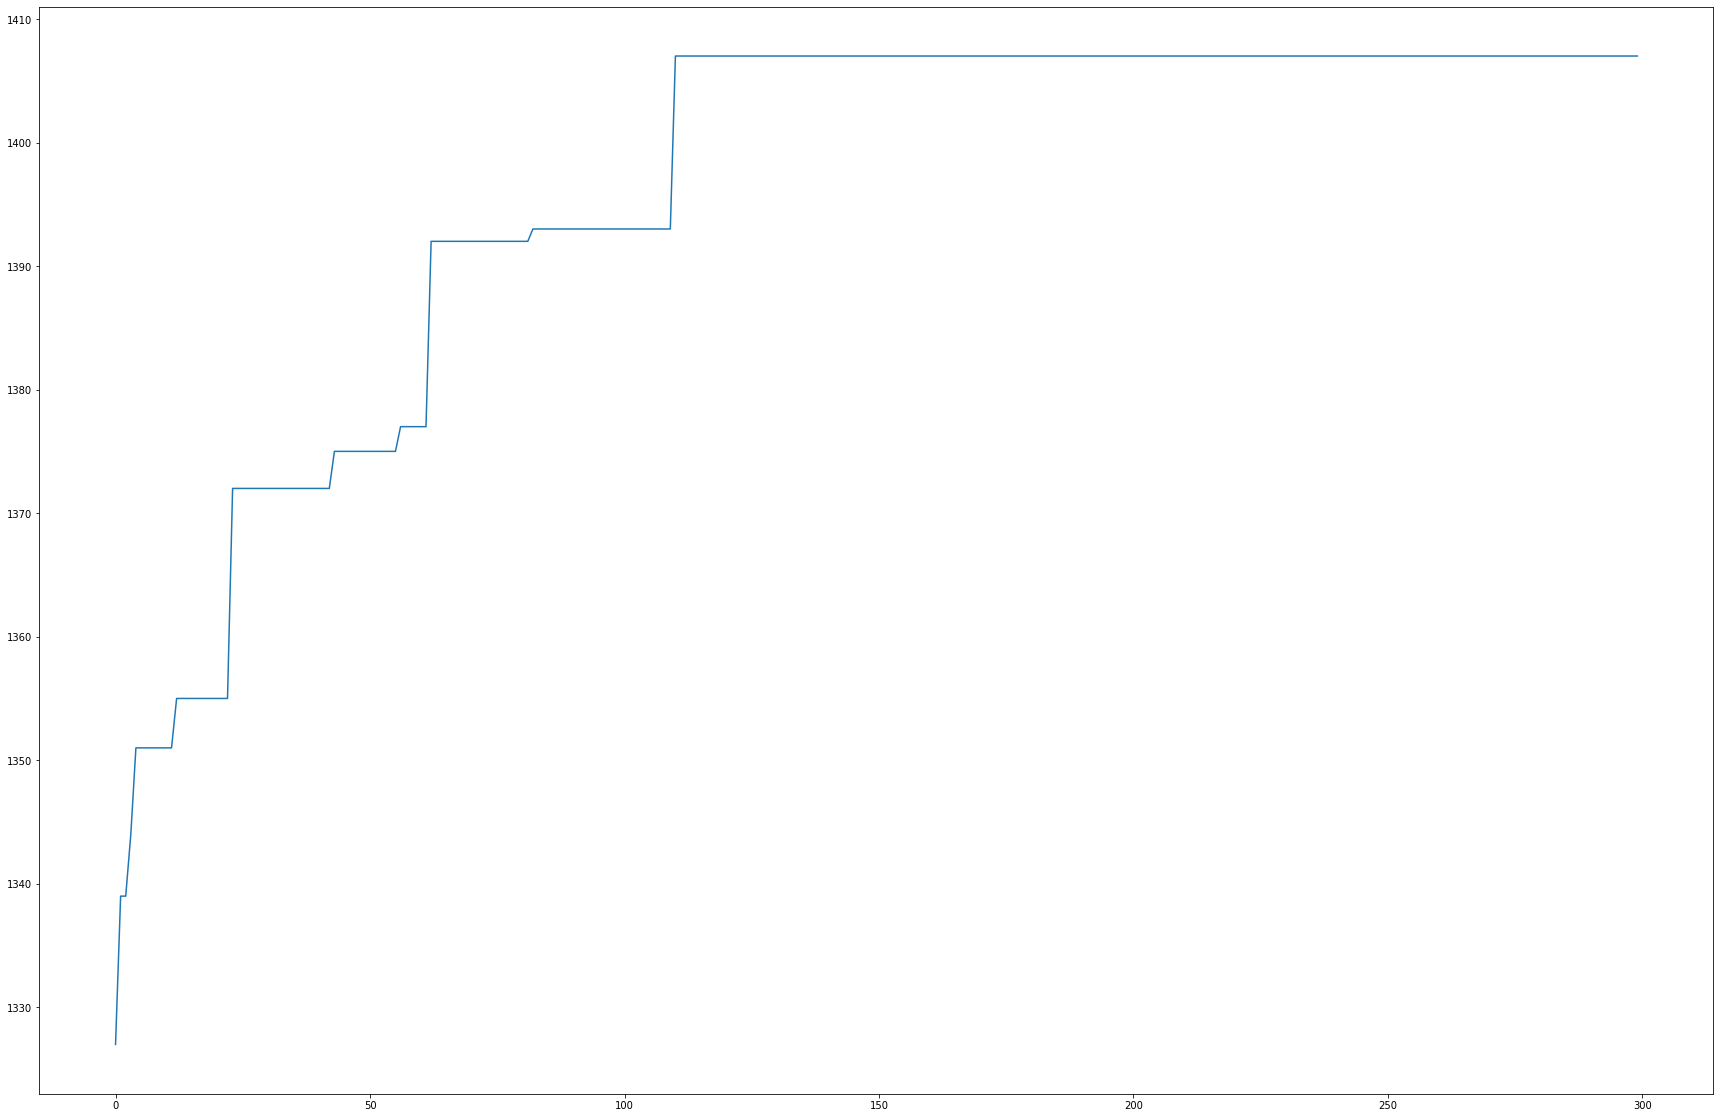

In [595]:
finalPop = simulation()

Generación 0: Score = 1342
Generación 10: Score = 1400
Generación 20: Score = 1400
Generación 30: Score = 1402
Generación 40: Score = 1402
Generación 50: Score = 1402
Generación 60: Score = 1402
Generación 70: Score = 1414
Generación 80: Score = 1414
Generación 90: Score = 1414
Generación 100: Score = 1415
Generación 110: Score = 1415
Generación 120: Score = 1415
Generación 130: Score = 1415
Generación 140: Score = 1415
Generación 150: Score = 1415
Generación 160: Score = 1415
Generación 170: Score = 1415
Generación 180: Score = 1415
Generación 190: Score = 1415
Generación 200: Score = 1415
Generación 210: Score = 1415
Generación 220: Score = 1415
Generación 230: Score = 1422
Generación 240: Score = 1422
Generación 250: Score = 1422
Generación 260: Score = 1422
Generación 270: Score = 1422
Generación 280: Score = 1422
Generación 290: Score = 1422
1422


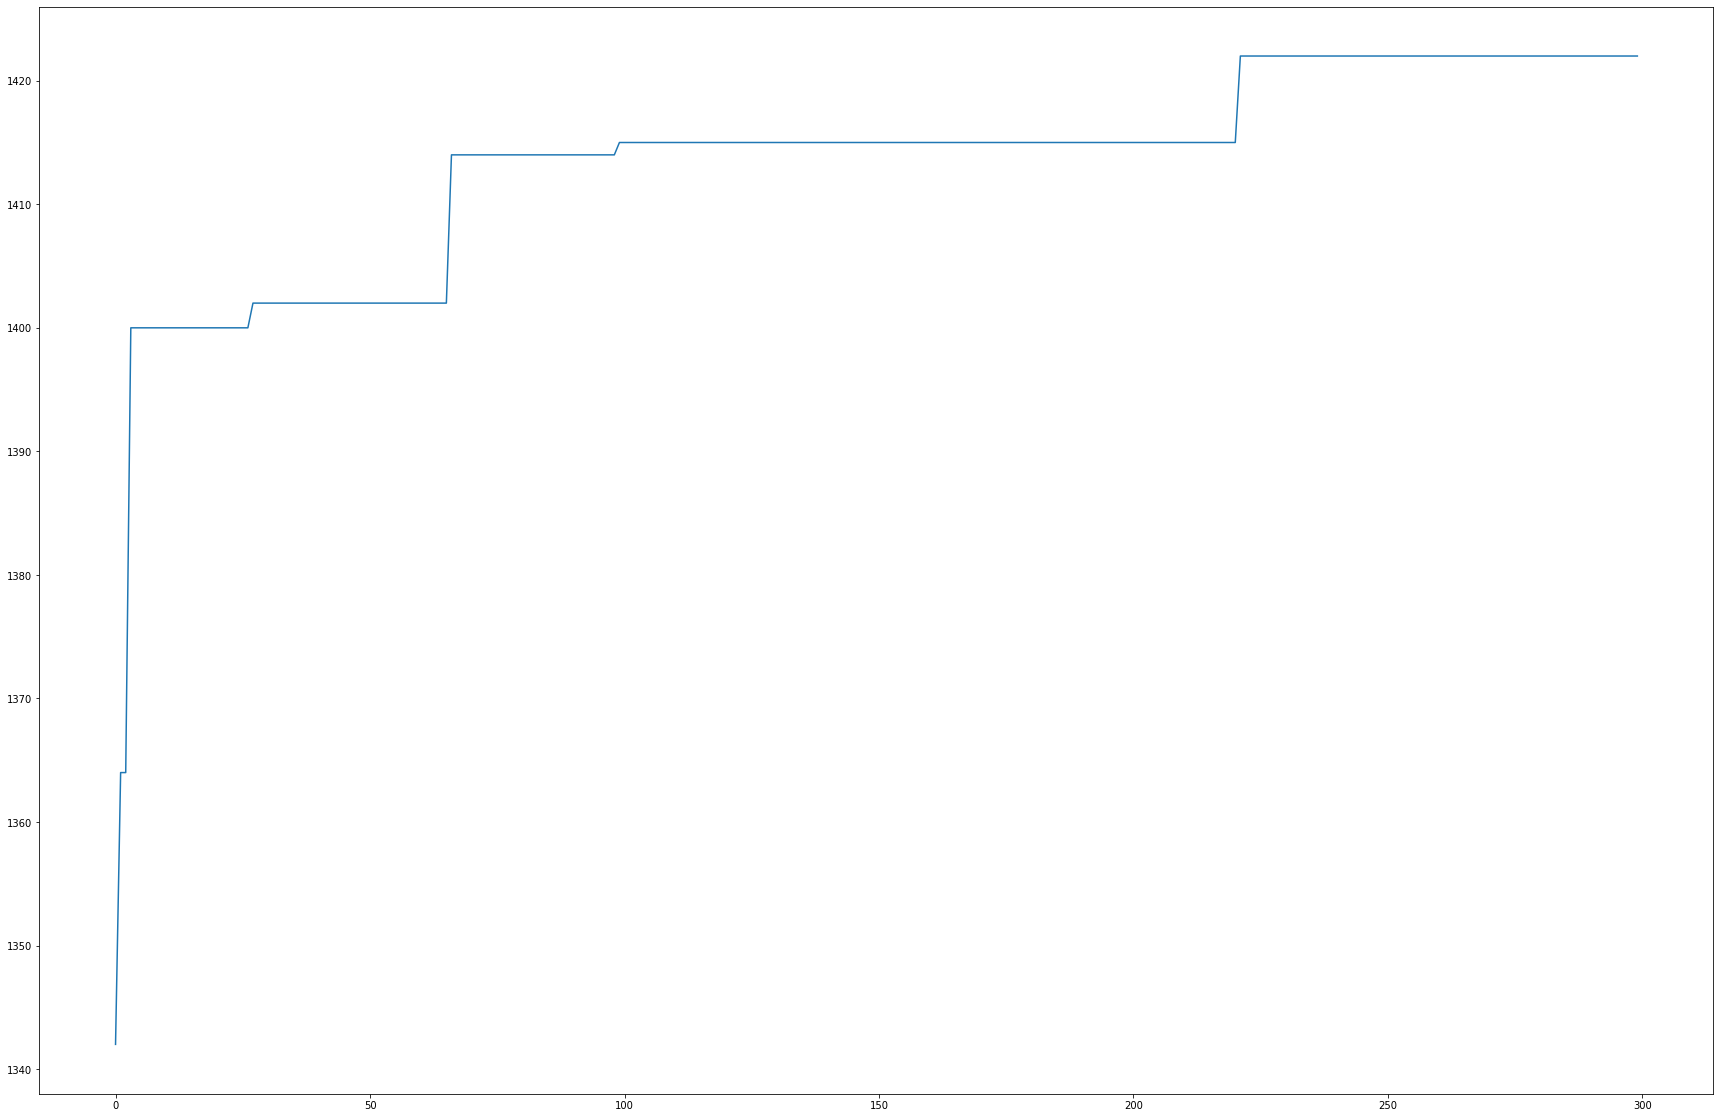

In [600]:
finalPop2 = simulation()

In [602]:
finalPop2[-1,:]

array([1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,

In [330]:
finalPop[:,idx]

array([[1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
        0],
       [0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        1],
       [0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
        1],
       [1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        0],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
        1],
       [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
        1],
       [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,

In [337]:
10*9*8*7*6*5*4*3*2

3628800